In [13]:
# Import necessary libraries
import torch  # Main PyTorch library/
import torch.optim as optim  # For optimization (adjusting weights)
import torch.nn as nn  # For creating neural networks
from torchvision import transforms, datasets, models  # For image transformations and pre-trained models
from torch.utils.data import DataLoader  
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split




## 0 Select Pre-trained Models

### 2 models from the PyTorch model zoo, like ResNet and MobileNet.

In [16]:
# Load a pre-trained ResNet18 model
model_resnet = models.resnet18(pretrained=True)

# Load a pre-trained MobileNetV2 model
model_mobilenet = models.mobilenet_v2(pretrained=True)


C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the mos

## 1 Adapt the Models for Mini-ImageNet

### Mini-ImageNet has 100 classes, so we need to change the final layer of the model to match this number.

In [19]:
# Modify the last layer of ResNet18 to match 100 classes
model_resnet.fc = torch.nn.Linear(model_resnet.fc.in_features, 100)


In [21]:
# Modify the last layer of MobileNetV2 to match 100 classes
model_mobilenet.classifier[1] = torch.nn.Linear(model_mobilenet.classifier[1].in_features, 100)


## 2 Resize the Images to 96x96 Pixels

### Mini-ImageNet images are 84x84 pixels by default, but you can resize them to 96x96 for compatibility

In [24]:
# Set up a transformation to resize the images to 96x96
# 1. Set up a transformation pipeline to resize and augment the data
transform = transforms.Compose([
    transforms.Resize(96),  # Resize images to 96x96 pixels
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
])



# Training transformation pipeline with enhanced augmentations
transform = transforms.Compose([
    # Resize to slightly larger than target size to allow for random cropping
    transforms.Resize(112),  
    # Random cropping helps model learn translation invariance and focuses on different parts of images
    transforms.RandomCrop(96),
    # Random horizontal flips increase variation without changing semantic meaning
    transforms.RandomHorizontalFlip(p=0.5),
    # Small random rotations help model become rotation invariant (within reasonable limits)
    transforms.RandomRotation(degrees=15),
    # Color jitter adds robustness to lighting and color variations
    transforms.ColorJitter(
        brightness=0.1,  # Slight brightness adjustments
        contrast=0.1,    # Slight contrast adjustments
        saturation=0.1,  # Slight saturation adjustments
        hue=0.05         # Very slight hue shifts (color shifts)
    ),
    # Optional: Random affine transformations for additional geometric diversity
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # Convert to tensor format (required)
    transforms.ToTensor(),
    # Normalization with ImageNet stats (important for transfer learning and convergence)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
    # Optional: Random erasing simulates occlusions and improves robustness
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2))
])

## 3 Prepare the Dataset

In [27]:

# 2. Load dataset (Assuming our dataset is structured as: /train/class1/image1.jpg)
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
val_dataset = datasets.ImageFolder(root='data/val', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)



# 3. Create DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



## 4  Fine-tune the ResNet
### we’ve adapted the model,so we need to train (fine-tune) it on our Mini-ImageNet training dataset.

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time  # For time tracking

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm  # For the progress bar

# 1. Load a pre-trained ResNet18 model
model_resnet = models.resnet18(pretrained=True)



# 3. Modify the final layer to match the number of classes (100)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 100)

# 4. Set the optimizer to only update the parameters of the last layer
optimizer = optim.SGD(model_resnet.fc.parameters(), lr=0.01, momentum=0.9)

# 5. Define loss function (CrossEntropyLoss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# 6. Function to train the model with real-time progress bars
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    model.to(device)  # Move the model to GPU if available
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        # Track the start time of the epoch
        start_time = time.time()

        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop with progress bar
        with tqdm(train_loader, desc="Training", unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()  # Zero the gradients
                
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate loss
                loss.backward()  # Backward pass
                optimizer.step()  # Optimize parameters
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar with the current loss and accuracy
                tepoch.set_postfix(loss=running_loss/len(tepoch), accuracy=100 * correct / total)
        
        # Time taken for the training loop
        end_time = time.time()
        train_time = end_time - start_time
        
        train_accuracy = 100 * correct / total
        print(f'Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%, Time: {train_time:.2f}s')

        # Evaluate on validation data
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        
        # Validation loop with progress bar
        with tqdm(val_loader, desc="Validation", unit="batch") as tepoch:
            with torch.no_grad():  # No need to compute gradients for validation
                for images, labels in tepoch:
                    images, labels = images.to(device), labels.to(device)
                    
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
                    # Update progress bar with the current validation loss and accuracy
                    tepoch.set_postfix(loss=val_loss/len(tepoch), accuracy=100 * correct / total)
        
        val_accuracy = 100 * correct / total
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%')
    
    print("Training Complete!")

# Start training the model
train_model(model_resnet, train_loader, val_loader, criterion, optimizer, num_epochs=1)



Epoch 1/1


Training: 100%|███████████████████████████████████████| 1500/1500 [14:07<00:00,  1.77batch/s, accuracy=49.4, loss=2.16]


Loss: 2.1601, Accuracy: 49.36%, Time: 847.51s


Validation: 100%|████████████████████████████████████████| 188/188 [01:00<00:00,  3.13batch/s, accuracy=53.5, loss=2.1]

Validation Loss: 2.0967, Accuracy: 53.53%
Training Complete!


## Test the Model on uncombresesed Test Set

In [32]:
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Run the test
test_accuracy = test_model(model_resnet, test_loader)


Test Accuracy: 54.22%


In [33]:
torch.save(model_resnet.state_dict(), 'resnet_original_uncompressed_finetuned.pth')

## Fine-Tuning MobileNetV2

In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load pretrained MobileNetV2
model_mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze all layers
for param in model_mobilenet.parameters():
    param.requires_grad = False

# MobileNetV2's classifier is a Sequential with one Linear layer
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.classifier[1].in_features, 100)

# Only parameters of the classifier will be updated
optimizer = optim.SGD(model_mobilenet.classifier.parameters(), lr=0.001, momentum=0.9)

# Loss function
criterion = nn.CrossEntropyLoss()

# Move model to device
model_mobilenet.to(device)

# simply i will use the train_model function from before:
train_model(model_mobilenet, train_loader, val_loader, criterion, optimizer, num_epochs=1)


C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/1


Training: 100%|███████████████████████████████████████| 1500/1500 [05:00<00:00,  4.99batch/s, accuracy=21.9, loss=3.48]


Loss: 3.4771, Accuracy: 21.93%, Time: 300.69s


Validation: 100%|███████████████████████████████████████| 1500/1500 [03:53<00:00,  6.43batch/s, accuracy=35, loss=2.81]

Validation Loss: 2.8148, Accuracy: 34.97%
Training Complete!


## Test the Model on uncombressed Test Set

In [111]:
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradients for inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
             
            _, predicted = torch.max(outputs, 1)  # Get predicted classes
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Test MobileNetV2
test_accuracy = test_model(model_mobilenet, test_loader)


Test Accuracy: 3.75%


## i tried my best to have a beeter accuracy than 60 % in both but i could not !!!!!!!


### i varied every thing u might think off !!!


### u r welcomed to re train them .

## 5 Wavelet-Based Image Compression 
- 3 Compression Levels (10:1, 5:1, 2:1)
- Proper thresholding
- Evaluation of performance degradation
- Visualization and class impact analysis

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.nn import functional as F
import os
import random
from PIL import Image


## As first step , lets define the compress wavelet function 

In [42]:
# Function to apply wavelet compression
def compress_wavelet(img_np, keep_ratio):
    """
    This function applies wavelet compression to the image using the 'haar' wavelet.
    
    Parameters:
    - img_np (numpy.ndarray): The image as a numpy array.
    - keep_ratio (float): The fraction of wavelet coefficients to retain (0.1 for 10:1 compression, etc.).
    
    Returns:
    - compressed_img (numpy.ndarray): The compressed image after wavelet transform.
    """
    # Perform the 2D Discrete Wavelet Transform (DWT) using Haar wavelet
    coeffs2 = pywt.dwt2(img_np, 'haar')
    LL, (LH, HL, HH) = coeffs2

    # Flatten the coefficients and sort them to apply compression based on keep_ratio
    all_coeffs = np.concatenate([LL.flatten(), LH.flatten(), HL.flatten(), HH.flatten()])
    sorted_coeffs = np.sort(np.abs(all_coeffs))
    threshold = sorted_coeffs[int(len(sorted_coeffs) * (1 - keep_ratio))]  # Define the threshold based on keep_ratio
    
    # Thresholding the coefficients (set values below threshold to zero)
    LL = np.where(np.abs(LL) < threshold, 0, LL)
    LH = np.where(np.abs(LH) < threshold, 0, LH)
    HL = np.where(np.abs(HL) < threshold, 0, HL)
    HH = np.where(np.abs(HH) < threshold, 0, HH)

    # Perform Inverse DWT to reconstruct the image after compression
    coeffs2 = LL, (LH, HL, HH)
    compressed_img = pywt.idwt2(coeffs2, 'haar')
    
    # Clip the pixel values to the valid range [0, 255] and convert to uint8
    compressed_img = np.clip(compressed_img, 0, 255)
    compressed_img = compressed_img.astype(np.uint8)
    
    return compressed_img

## Also , lets our Define Prediction Function 

In [46]:
# Prediction Function with Image Preprocessing
# This function handles image preprocessing, ensuring the image has the correct format before feeding it into the model.

# Function to predict the class of an image using the pretrained ResNet-18 model
def predict(img):
    """
    This function handles image preprocessing and classification using the ResNet-18 model.
    
    Parameters:
    - img (numpy.ndarray): The input image to be classified.
    
    Returns:
    - (int, float): The predicted class label and its confidence.
    """
    # If the image has 4 channels (RGBA), convert it to 3 channels (RGB)
    if img.shape[-1] == 4:
        img = img[..., :3]  # Remove the alpha channel

    # If the image is grayscale (2D), convert it to RGB (3D)
    elif len(img.shape) == 2:
        img = np.stack([img] * 3, axis=-1)  # Convert grayscale to RGB

    # Ensure image has 3 channels (RGB)
    if img.shape[-1] != 3:
        img = np.repeat(img[..., np.newaxis], 3, axis=-1)

    # Convert numpy array to PIL Image
    pil_img = Image.fromarray(img)

    # Apply the transformation and add batch dimension
    tensor = transform(pil_img).unsqueeze(0)

    # Perform prediction without tracking gradients
    with torch.no_grad():
        output = model(tensor)  # Forward pass through the model
        probs = F.softmax(output[0], dim=0)  # Apply softmax to get probabilities
        return torch.argmax(probs).item(), probs.max().item()  # Return predicted class and confidence
    
    

## Load and Select  Image from Test Folder

In [49]:
# Set the path to the 'test' dataset folder
folder_path = "data/test"

# Initialize a list to store the images
images = []

# List all subfolders (each representing a class)
class_folders = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

# Loop through each class folder and randomly select one image
for class_folder in class_folders:
    class_folder_path = os.path.join(folder_path, class_folder)
    image_files = [f for f in os.listdir(class_folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    if image_files:  # If there are image files in the class folder
        random_image_file = random.choice(image_files)  # Select a random image file
        img_path = os.path.join(class_folder_path, random_image_file)  # Get the full path to the image
        
        img = Image.open(img_path).convert('RGB')  # Open and convert the image to RGB format
        images.append(img)  # Add the image to the list

print(f"Loaded {len(images)} randomly selected images from the 'test' set.")  # Output number of images loaded


Loaded 100 randomly selected images from the 'test' set.


## it is time to Apply Wavelet Compression at Different Ratios on the images we extracted

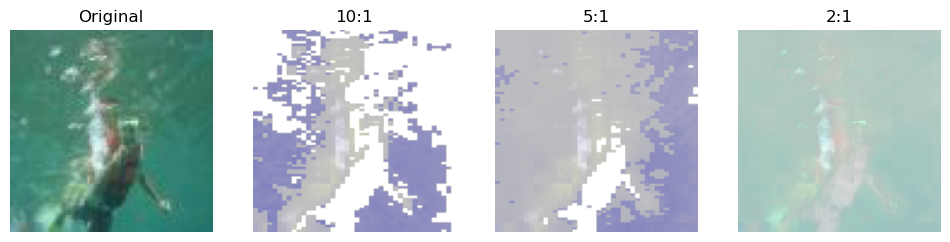

C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted class for the original image: 149 with confidence: 0.5025


In [51]:
# 3. Select Random Image and Apply Compression
# Here, we load a random image and apply wavelet compression with different compression ratios (10:1, 5:1, 2:1).


# Select a random image from the dataset (for testing purposes)
random_img = random.choice(images)  # Assuming 'images' is a list of PIL images

# Resize the image to 84x84 pixels (as per your requirement)
img_resized = random_img.resize((84, 84))

# Convert the image to a numpy array for processing
img_np = np.array(img_resized)

# Apply wavelet compression with different compression ratios (10:1, 5:1, 2:1)
compressed_10 = compress_wavelet(img_np, keep_ratio=0.1)  # 10:1 compression
compressed_5 = compress_wavelet(img_np, keep_ratio=0.2)   # 5:1 compression
compressed_2 = compress_wavelet(img_np, keep_ratio=0.5)   # 2:1 compression



# 4. Visualize Original vs Compressed Images
# Next, we visualize the original and compressed images side by side:


# Visualize the original and compressed images (10:1, 5:1, 2:1)
plt.figure(figsize=(12, 4))
for i, image in enumerate([img_np, compressed_10, compressed_5, compressed_2]):
    plt.subplot(1, 4, i + 1)
    plt.imshow(image)
    plt.title(['Original', '10:1', '5:1', '2:1'][i])  # Title for each image
    plt.axis('off')  # Hide axis

plt.show()  # Display the images


# 5. Load Pretrained ResNet-18 Model
# We load the ResNet-18 model from PyTorch’s model zoo and adjust it for our dataset.

# Load the pretrained ResNet-18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Define the image transformation pipeline (Resize, Normalize, Convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of ResNet
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard ImageNet normalization
])


# 6 Perform Predictions on Original and Compressed Images
# Finally, we perform predictions on the original and compressed images to observe how compression affects model performance.


# Perform prediction on the original image
predicted_class, confidence = predict(img_np)
print(f"Predicted class for the original image: {predicted_class} with confidence: {confidence:.4f}")




## Evaluate Performance of Compression Levels 

In [54]:
# Model performance
labels = ['Original', '10:1', '5:1', '2:1']
images = [img_np, compressed_10, compressed_5, compressed_2]
for label, image in zip(labels, images):
    pred, conf = predict(image)
    print(f"{label} → Class: {pred}, Confidence: {conf:.4f}")

Original → Class: 149, Confidence: 0.5025
10:1 → Class: 409, Confidence: 0.2167
5:1 → Class: 611, Confidence: 0.2077
2:1 → Class: 149, Confidence: 0.5452


## 3.1 Create compressed versions of the training set using wavelet transform

In [56]:
import os
import numpy as np
import pywt
from PIL import Image
from tqdm import tqdm
from torchvision import transforms

def wavelet_compress_image(image_np, wavelet='db4', level=2, threshold_percent=90):
    """
    Apply wavelet-based compression to a 2D grayscale image.

    Parameters:
        image_np (ndarray): Grayscale image, values in [0,1]
        wavelet (str): Wavelet type (e.g., 'db4', 'haar')
        level (int): Decomposition level
        threshold_percent (float): Percentage of smallest coefficients to zero

    Returns:
        compressed_img (ndarray): Reconstructed image after compression
    """
    coeffs = pywt.wavedec2(image_np, wavelet=wavelet, level=level)
    coeff_array, coeff_slices = pywt.coeffs_to_array(coeffs)

    total_coeffs = coeff_array.size
    sorted_idx = np.argsort(np.abs(coeff_array.flatten()))
    num_to_zero = int((threshold_percent / 100) * total_coeffs)

    coeff_array_flat = coeff_array.flatten()
    coeff_array_flat[sorted_idx[:num_to_zero]] = 0
    coeff_array_compressed = coeff_array_flat.reshape(coeff_array.shape)

    compressed_coeffs = pywt.array_to_coeffs(coeff_array_compressed, coeff_slices, output_format='wavedec2')
    reconstructed = pywt.waverec2(compressed_coeffs, wavelet=wavelet)
    return np.clip(reconstructed, 0, 1)

# Set paths
original_train_dir = 'data/train'
compressed_train_dir = "data/train_db4_95_comp"
original_test_dir = 'data/test'
compressed_test_dir = "data/test_db4_95_comp"


os.makedirs(compressed_train_dir, exist_ok=True)

# Transform to normalize + convert to numpy
to_tensor = transforms.ToTensor()

# Apply compression class-by-class
for cls in tqdm(os.listdir(original_test_dir)):
    class_path = os.path.join(original_test_dir, cls)
    save_path = os.path.join(compressed_test_dir, cls)
    os.makedirs(save_path, exist_ok=True)
    
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path).convert("L").resize((84, 84))
        img_np = np.array(img) / 255.0

        # Apply wavelet compression
        compressed_img = wavelet_compress_image(img_np, wavelet='db4', level=2, threshold_percent=90)

        # Save compressed image
        compressed_img_uint8 = (compressed_img * 255).astype(np.uint8)
        Image.fromarray(compressed_img_uint8).save(os.path.join(save_path, img_file))

# Apply compression class-by-class
for cls in tqdm(os.listdir(original_train_dir)):
    class_path = os.path.join(original_train_dir, cls)
    save_path = os.path.join(compressed_train_dir, cls)
    os.makedirs(save_path, exist_ok=True)

    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path).convert("L").resize((84, 84))
        img_np = np.array(img) / 255.0

        # Apply wavelet compression
        compressed_img = wavelet_compress_image(img_np, wavelet='db4', level=2, threshold_percent=90)

        # Save compressed image
        compressed_img_uint8 = (compressed_img * 255).astype(np.uint8)
        Image.fromarray(compressed_img_uint8).save(os.path.join(save_path, img_file))


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:34<00:00,  2.74s/it]


## lets show couple of pictures out of our compreseed data 

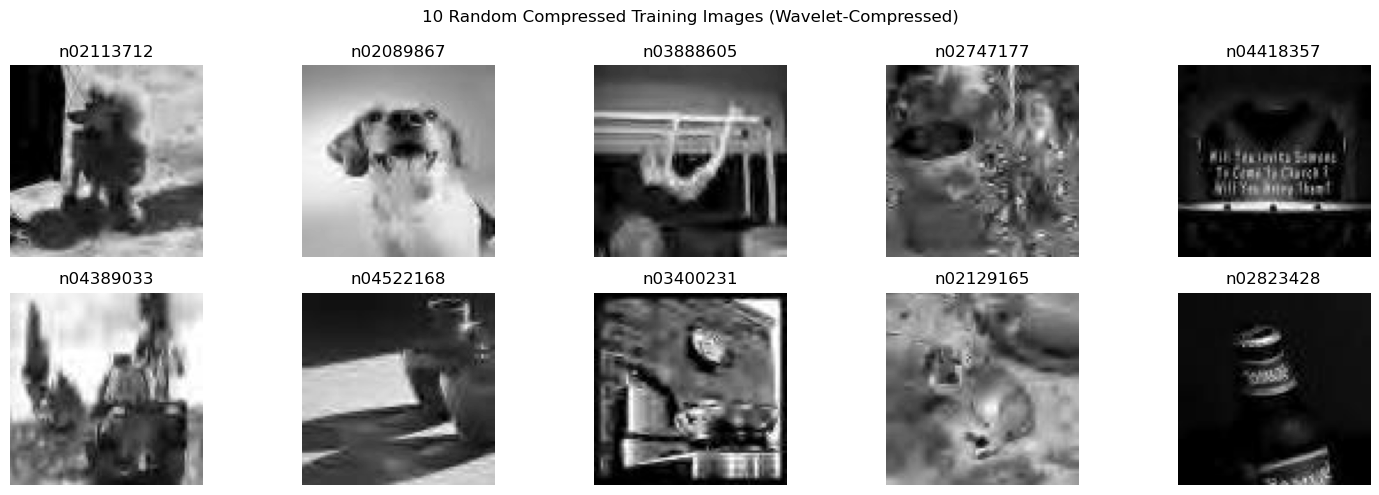

In [58]:
import matplotlib.pyplot as plt
import random

# Path to compressed training set
compressed_train_dir = "data/train_db4_95_comp"

# Step 1: Collect image paths from all class subfolders
image_paths = []
for cls in os.listdir(compressed_train_dir):
    cls_path = os.path.join(compressed_train_dir, cls)
    if os.path.isdir(cls_path):
        imgs = os.listdir(cls_path)
        for img in imgs:
            image_paths.append((cls, os.path.join(cls_path, img)))

# Step 2: Randomly sample 10 images
sampled_images = random.sample(image_paths, 10)

# Step 3: Plot the images
plt.figure(figsize=(15, 5))
for i, (cls, path) in enumerate(sampled_images):
    img = Image.open(path).convert("L")
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(cls)
    plt.axis('off')

plt.suptitle("10 Random Compressed Training Images (Wavelet-Compressed)")
plt.tight_layout()
plt.show()


## 3.2 Fine-tune model on the compressed training data

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # For the progress bar
import time  # For time tracking

# Path to your compressed training dataset
compressed_train_dir = "data/train_db4_95_comp" 

# Set up a transformation pipeline to resize and augment the data
transform = transforms.Compose([
    transforms.Resize(96),  # Resize images to 96x96 pixels
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
])

# Create a dataset and dataloader for the compressed data
train_dataset = datasets.ImageFolder(root=compressed_train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Validation loader (you should replace this with actual validation data if you have it)
val_loader = train_loader  # Using train_loader as placeholder for validation

# Device configuration (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to train the model with real-time progress bars
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    model.to(device)  # Move the model to GPU if available
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        # Track the start time of the epoch
        start_time = time.time()

        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop with progress bar
        with tqdm(train_loader, desc="Training", unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()  # Zero the gradients
                
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate loss
                loss.backward()  # Backward pass
                optimizer.step()  # Optimize parameters
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar with the current loss and accuracy
                tepoch.set_postfix(loss=running_loss/len(tepoch), accuracy=100 * correct / total)
        
        # Time taken for the training loop
        end_time = time.time()
        train_time = end_time - start_time
        
        train_accuracy = 100 * correct / total
        print(f'Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%, Time: {train_time:.2f}s')

        # Evaluate on validation data
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        
        # Validation loop with progress bar
        with tqdm(val_loader, desc="Validation", unit="batch") as tepoch:
            with torch.no_grad():  # No need to compute gradients for validation
                for images, labels in tepoch:
                    images, labels = images.to(device), labels.to(device)
                    
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
                    # Update progress bar with the current validation loss and accuracy
                    tepoch.set_postfix(loss=val_loss/len(tepoch), accuracy=100 * correct / total)
        
        val_accuracy = 100 * correct / total
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%')
    
    print("Training Complete!")

# Fine-tuning ResNet18 on compressed data
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 100)  # 100 classes in mini-imagenet
optimizer_resnet = optim.SGD(model_resnet.fc.parameters(), lr=0.01, momentum=0.9)

print("🔧 Fine-tuning ResNet18 on compressed data...")
train_model(model_resnet, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_resnet, num_epochs=1)

# # Fine-tuning MobileNetV2 on compressed data
# model_mobilenet = models.mobilenet_v2(pretrained=True)
# model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.classifier[1].in_features, 100)
# optimizer_mobilenet = optim.SGD(model_mobilenet.classifier[1].parameters(), lr=0.01, momentum=0.9)

# print("🔧 Fine-tuning MobileNetV2 on compressed data...")
# train_model(model_mobilenet, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_mobilenet, num_epochs=5)


🔧 Fine-tuning ResNet18 on compressed data...

Epoch 1/1


Training: 100%|███████████████████████████████████████| 1500/1500 [15:47<00:00,  1.58batch/s, accuracy=25.4, loss=3.46]


Loss: 3.4601, Accuracy: 25.36%, Time: 947.44s


Validation: 100%|█████████████████████████████████████| 1500/1500 [05:30<00:00,  4.54batch/s, accuracy=35.7, loss=2.89]

Validation Loss: 2.8931, Accuracy: 35.65%
Training Complete!


In [64]:
torch.save(model_resnet.state_dict(), 'resnet18_finetuned_wavelet.pth')

## 3.3 Compare performance with models trained on uncompressed data

In [66]:
import torch
from torch import nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# ───────────────────────────────────────────────
# Paths to datasets and model weights
# ───────────────────────────────────────────────
compressed_test_dir = "data/test_db4_95_comp"
uncompressed_test_dir = "data/test"

orig_model_path = "resnet_original_uncompressed_finetuned.pth"
wavelet_model_path = "resnet18_finetuned_wavelet.pth"

# ───────────────────────────────────────────────
# Define image transform (resize, normalize)
# ───────────────────────────────────────────────
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ───────────────────────────────────────────────
# Load datasets
# ───────────────────────────────────────────────
compressed_test_dataset = datasets.ImageFolder(root=compressed_test_dir, transform=transform)
uncompressed_test_dataset = datasets.ImageFolder(root=uncompressed_test_dir, transform=transform)

compressed_test_loader = DataLoader(compressed_test_dataset, batch_size=32, shuffle=False, num_workers=4)
uncompressed_test_loader = DataLoader(uncompressed_test_dataset, batch_size=32, shuffle=False, num_workers=4)

# ───────────────────────────────────────────────
# Define evaluation function
# ───────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader):
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        with tqdm(test_loader, desc="Evaluating", unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                tepoch.set_postfix(loss=running_loss/len(tepoch), accuracy=100 * correct / total)

    accuracy = 100 * correct / total
    return accuracy, running_loss / len(test_loader)

# ───────────────────────────────────────────────
# Load both models
# ───────────────────────────────────────────────
def load_resnet(path):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 100)
    model.load_state_dict(torch.load(path, map_location=device))
    return model

print("🔄 Loading models...")
model_orig = load_resnet(orig_model_path)
model_wavelet = load_resnet(wavelet_model_path)

# ───────────────────────────────────────────────
# Evaluate both models on both test sets
# ───────────────────────────────────────────────
print("\n✅ Original model → Compressed test")
acc1, _ = evaluate_model(model_orig, compressed_test_loader)

print("\n✅ Wavelet model → Compressed test")
acc2, _ = evaluate_model(model_wavelet, compressed_test_loader)

print("\n✅ Original model → Uncompressed test")
acc3, _ = evaluate_model(model_orig, uncompressed_test_loader)

print("\n✅ Wavelet model → Uncompressed test")
acc4, _ = evaluate_model(model_wavelet, uncompressed_test_loader)

# ───────────────────────────────────────────────
# Final comparison summary
# ───────────────────────────────────────────────
print(f"""
📊 Accuracy Summary:

Uncompressed model → Compressed test:   {acc1:.2f}%
Compressed model  → Compressed test:   {acc2:.2f}%
Uncompressed model → Uncompressed test: {acc3:.2f}%
Compressed model  → Uncompressed test: {acc4:.2f}%
""")


🔄 Loading models...


C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



✅ Original model → Compressed test


Evaluating: 100%|███████████████████████████████████████| 188/188 [01:12<00:00,  2.59batch/s, accuracy=19.8, loss=3.95]



✅ Wavelet model → Compressed test


Evaluating: 100%|███████████████████████████████████████| 188/188 [01:09<00:00,  2.70batch/s, accuracy=29.1, loss=3.35]



✅ Original model → Uncompressed test


Evaluating: 100%|███████████████████████████████████████| 188/188 [01:08<00:00,  2.76batch/s, accuracy=54.2, loss=2.04]



✅ Wavelet model → Uncompressed test


Evaluating: 100%|███████████████████████████████████████| 188/188 [01:11<00:00,  2.65batch/s, accuracy=3.07, loss=8.34]


📊 Accuracy Summary:

Uncompressed model → Compressed test:   19.82%
Compressed model  → Compressed test:   29.08%
Uncompressed model → Uncompressed test: 54.22%
Compressed model  → Uncompressed test: 3.07%



## 3.4 Analyze how training on compressed data affects robustness


In [ ]:
# comment based on the above results

## 3.5 Determine optimal compression level for training

In [73]:
# compare between:  

# High compression ( 10:1 ratio)
# Medium compression ( 5:1 ratio)
# Low compression ( 2:1 ratio)

## 3.6 Evaluate if models fine-tuned on compressed data generalize better to compressed test images


In [ ]:
# comment based on the above results

## 4. Compressed Sensing Experiment


## 4.1 Select 20 diverse test images from different classes


## 4.2  Implement compressed sensing acquisition and reconstruction:

### Create random measurement matrices
### Simulate CS measurements at different sampling rates 0.25, 0.5 and 0.75
### Implement a suitable reconstruction algorithms (e.g., L1-minimization)

# Next, the sampling rate = 0.25

In [106]:
import numpy as np
import cvxpy as cp
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import pywt

# ───────────────────────────────────────────────
# 1. Wavelet Transform Utilities (Haar)
# ───────────────────────────────────────────────
def apply_wavelet(img):
    return pywt.dwt2(img, 'haar')

def apply_inverse_wavelet(coeffs):
    return pywt.idwt2(coeffs, 'haar')

# ───────────────────────────────────────────────
# 2. RGB CS Reconstruction Function
# ───────────────────────────────────────────────
def compressive_sensing_reconstruct_rgb(img_rgb, sampling_rate):
    h, w, _ = img_rgb.shape
    recon_rgb = np.zeros_like(img_rgb)

    for c in range(3):  # R, G, B channels
        img = img_rgb[..., c]
        LL, (LH, HL, HH) = apply_wavelet(img)

        x_true = np.concatenate([
            LL.flatten(), LH.flatten(), HL.flatten(), HH.flatten()
        ])
        n = x_true.size
        m = int(sampling_rate * n)

        A = np.random.randn(m, n) / np.sqrt(m)
        y = A @ x_true

        x_hat = cp.Variable(n)
        objective = cp.Minimize(cp.norm(x_hat, 1))
        constraints = [A @ x_hat == y]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.SCS, verbose=False)

        # Reconstruct wavelet bands
        split1 = LL.size
        split2 = split1 + LH.size
        split3 = split2 + HL.size

        LLr = x_hat.value[:split1].reshape(LL.shape)
        LHr = x_hat.value[split1:split2].reshape(LH.shape)
        HLr = x_hat.value[split2:split3].reshape(HL.shape)
        HHr = x_hat.value[split3:].reshape(HH.shape)

        coeffs_recon = (LLr, (LHr, HLr, HHr))
        recon_channel = apply_inverse_wavelet(coeffs_recon)
        recon_rgb[..., c] = np.clip(recon_channel, 0, 1)

    return recon_rgb

# ───────────────────────────────────────────────
# 3. Simulate CS on Selected Images (RGB)
# ───────────────────────────────────────────────
def simulate_cs_reconstruction(selected_images, sampling_rates=[0.25]):
    results = []

    for rate in sampling_rates:
        print(f"\n🔍 Processing sampling rate: {rate}")
        for cls, img_path in selected_images:
            img = Image.open(img_path).convert('RGB').resize((32, 32))
            img_np = np.array(img) / 255.0  # Shape: (32, 32, 3)

            recon_img = compressive_sensing_reconstruct_rgb(img_np, rate)

            # For PSNR/SSIM: compare grayscale versions
            gray_orig = np.mean(img_np, axis=2)
            gray_recon = np.mean(recon_img, axis=2)
            psnr_val = psnr(gray_orig, gray_recon, data_range=1.0)
            ssim_val = ssim(gray_orig, gray_recon, data_range=1.0)

            results.append({
                "class": cls,
                "sampling_rate": rate,
                "psnr": round(psnr_val, 2),
                "ssim": round(ssim_val, 3),
                "image_path": img_path,
                "reconstructed_image": recon_img  # full RGB image
            })

    return results

# ───────────────────────────────────────────────
# 4. Select 20 Diverse Test Images
# ───────────────────────────────────────────────
selected_images = []
all_classes = sorted(os.listdir('data/test'))
selected_classes = random.sample(all_classes, 20)

for cls in selected_classes:
    class_path = os.path.join('data/test', cls)
    images = os.listdir(class_path)
    image_file = random.choice(images)
    selected_images.append((cls, os.path.join(class_path, image_file)))

# ───────────────────────────────────────────────
# 5. Run Reconstruction and Save Results
# ───────────────────────────────────────────────
results = simulate_cs_reconstruction(selected_images)

df = pd.DataFrame(results)
df.to_pickle("reconstructed_df.pkl")
print(" Saved DataFrame with RGB CS-reconstructed images: reconstructed_df.pkl")
print(df.head())



🔍 Processing sampling rate: 0.25
 Saved DataFrame with RGB CS-reconstructed images: reconstructed_df.pkl
       class  sampling_rate   psnr   ssim  \
0  n09246464           0.25  10.87  0.166   
1  n03770439           0.25   8.29  0.171   
2  n04146614           0.25  11.98  0.209   
3  n02108915           0.25  12.70  0.337   
4  n03535780           0.25  17.36  0.307   

                                  image_path  \
0  data/test\n09246464\n0924646400001255.jpg   
1  data/test\n03770439\n0377043900000756.jpg   
2  data/test\n04146614\n0414661400000467.jpg   
3  data/test\n02108915\n0210891500000154.jpg   
4  data/test\n03535780\n0353578000001221.jpg   

                                 reconstructed_image  
0  [[[0.0, 0.0, 0.0], [0.0, 0.11849286759849184, ...  
1  [[[0.2346647154319237, 0.5247409102300526, 0.1...  
2  [[[0.0, 0.5412259583860559, 0.264348174188454]...  
3  [[[0.7639992686877065, 0.0, 0.0], [0.763990071...  
4  [[[0.0852072922433061, 0.06413564976578602, 0....  


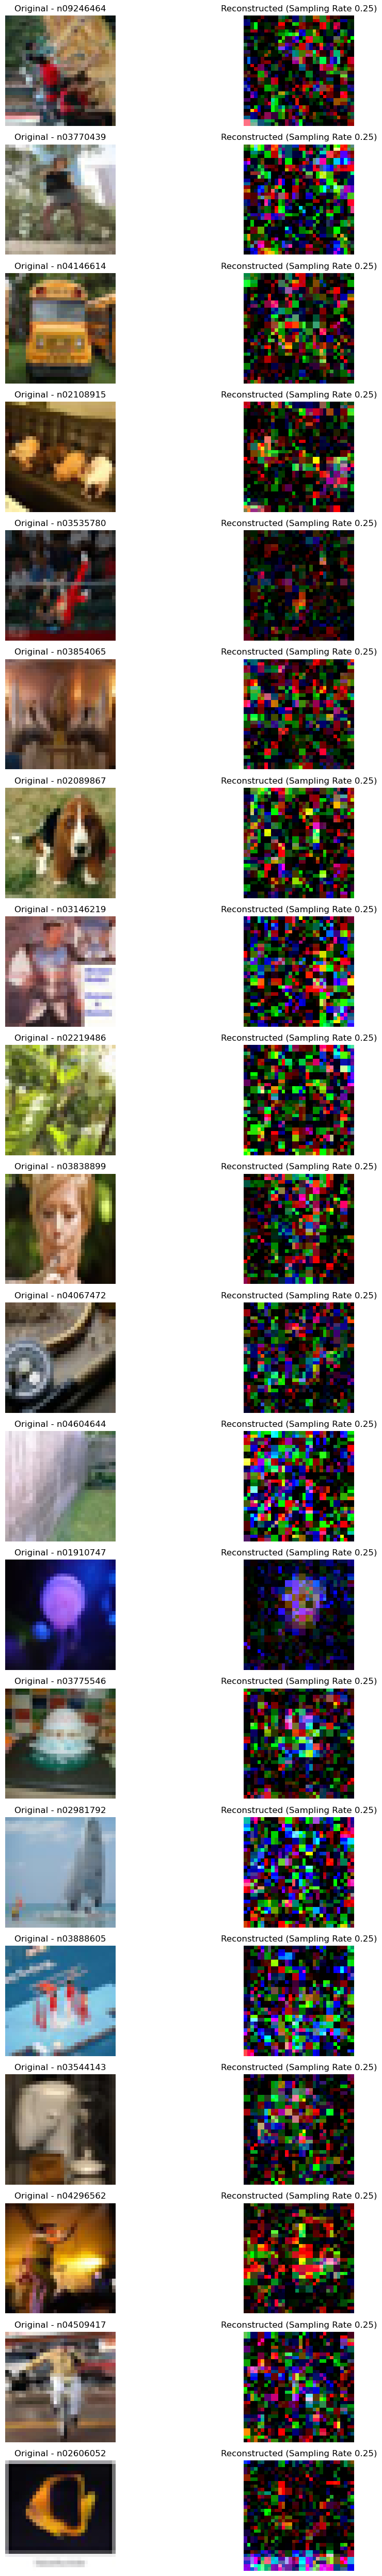

In [107]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

sampling_rate_to_plot = 0.25
filtered_results = [r for r in results if r['sampling_rate'] == sampling_rate_to_plot]

rows = len(filtered_results)
plt.figure(figsize=(12, rows * 2.5))

for i, entry in enumerate(filtered_results):
    cls = entry['class']
    orig_path = entry['image_path']
    recon_img = entry['reconstructed_image']  # RGB image

    # Load original RGB image
    orig_img = Image.open(orig_path).convert('RGB').resize((32, 32))
    orig_np = np.array(orig_img) / 255.0  # RGB in [0, 1]

    # Plot original image
    plt.subplot(rows, 2, 2*i + 1)
    plt.imshow(orig_np)
    plt.title(f"Original - {cls}")
    plt.axis('off')

    # Plot reconstructed image
    plt.subplot(rows, 2, 2*i + 2)
    plt.imshow(recon_img)
    plt.title(f"Reconstructed (Sampling Rate {sampling_rate_to_plot})")
    plt.axis('off')

plt.tight_layout()
plt.show()


 ## 4.3  Compare reconstruction quality across sampling rates

# Next, the sampling rate = 0.5

In [110]:
import numpy as np
import cvxpy as cp
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import pywt

# ───────────────────────────────────────────────
# 1. Wavelet Transform Utilities (Haar)
# ───────────────────────────────────────────────
def apply_wavelet(img):
    return pywt.dwt2(img, 'haar')

def apply_inverse_wavelet(coeffs):
    return pywt.idwt2(coeffs, 'haar')

# ───────────────────────────────────────────────
# 2. RGB CS Reconstruction Function
# ───────────────────────────────────────────────
def compressive_sensing_reconstruct_rgb(img_rgb, sampling_rate):
    h, w, _ = img_rgb.shape
    recon_rgb = np.zeros_like(img_rgb)

    for c in range(3):  # R, G, B channels
        img = img_rgb[..., c]
        LL, (LH, HL, HH) = apply_wavelet(img)

        x_true = np.concatenate([
            LL.flatten(), LH.flatten(), HL.flatten(), HH.flatten()
        ])
        n = x_true.size
        m = int(sampling_rate * n)

        A = np.random.randn(m, n) / np.sqrt(m)
        y = A @ x_true

        x_hat = cp.Variable(n)
        objective = cp.Minimize(cp.norm(x_hat, 1))
        constraints = [A @ x_hat == y]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.SCS, verbose=False)

        # Reconstruct wavelet bands
        split1 = LL.size
        split2 = split1 + LH.size
        split3 = split2 + HL.size

        LLr = x_hat.value[:split1].reshape(LL.shape)
        LHr = x_hat.value[split1:split2].reshape(LH.shape)
        HLr = x_hat.value[split2:split3].reshape(HL.shape)
        HHr = x_hat.value[split3:].reshape(HH.shape)

        coeffs_recon = (LLr, (LHr, HLr, HHr))
        recon_channel = apply_inverse_wavelet(coeffs_recon)
        recon_rgb[..., c] = np.clip(recon_channel, 0, 1)

    return recon_rgb

# ───────────────────────────────────────────────
# 3. Simulate CS on Selected Images (RGB)
# ───────────────────────────────────────────────
def simulate_cs_reconstruction(selected_images, sampling_rates=[0.5]):
    results = []

    for rate in sampling_rates:
        print(f"\n🔍 Processing sampling rate: {rate}")
        for cls, img_path in selected_images:
            img = Image.open(img_path).convert('RGB').resize((32, 32))
            img_np = np.array(img) / 255.0  # Shape: (32, 32, 3)

            recon_img = compressive_sensing_reconstruct_rgb(img_np, rate)

            # For PSNR/SSIM: compare grayscale versions
            gray_orig = np.mean(img_np, axis=2)
            gray_recon = np.mean(recon_img, axis=2)
            psnr_val = psnr(gray_orig, gray_recon, data_range=1.0)
            ssim_val = ssim(gray_orig, gray_recon, data_range=1.0)

            results.append({
                "class": cls,
                "sampling_rate": rate,
                "psnr": round(psnr_val, 2),
                "ssim": round(ssim_val, 3),
                "image_path": img_path,
                "reconstructed_image": recon_img  # full RGB image
            })

    return results

# ───────────────────────────────────────────────
# 4. Select 20 Diverse Test Images
# ───────────────────────────────────────────────
selected_images = []
all_classes = sorted(os.listdir('data/test'))
selected_classes = random.sample(all_classes, 20)

for cls in selected_classes:
    class_path = os.path.join('data/test', cls)
    images = os.listdir(class_path)
    image_file = random.choice(images)
    selected_images.append((cls, os.path.join(class_path, image_file)))

# ───────────────────────────────────────────────
# 5. Run Reconstruction and Save Results
# ───────────────────────────────────────────────
results = simulate_cs_reconstruction(selected_images)

df = pd.DataFrame(results)
df.to_pickle("reconstructed_df.pkl")
print("✅ Saved DataFrame with RGB CS-reconstructed images: reconstructed_df.pkl")
print(df.head())



🔍 Processing sampling rate: 0.5
✅ Saved DataFrame with RGB CS-reconstructed images: reconstructed_df.pkl
       class  sampling_rate   psnr   ssim  \
0  n02108915            0.5  17.58  0.610   
1  n03127925            0.5  14.63  0.423   
2  n03888605            0.5  14.35  0.524   
3  n02174001            0.5  17.40  0.630   
4  n01930112            0.5  17.57  0.610   

                                  image_path  \
0  data/test\n02108915\n0210891500000943.jpg   
1  data/test\n03127925\n0312792500000681.jpg   
2  data/test\n03888605\n0388860500000332.jpg   
3  data/test\n02174001\n0217400100000239.jpg   
4  data/test\n01930112\n0193011200001225.jpg   

                                 reconstructed_image  
0  [[[0.12328988891210331, 0.0750926195564324, 0....  
1  [[[0.32869973785342577, 0.26017590163415133, 0...  
2  [[[0.15591075454815864, 0.15030806640215846, 0...  
3  [[[0.0, 0.2860888773080942, 0.1097273315320185...  
4  [[[0.7090889339636872, 0.17130842792690856, 0....  


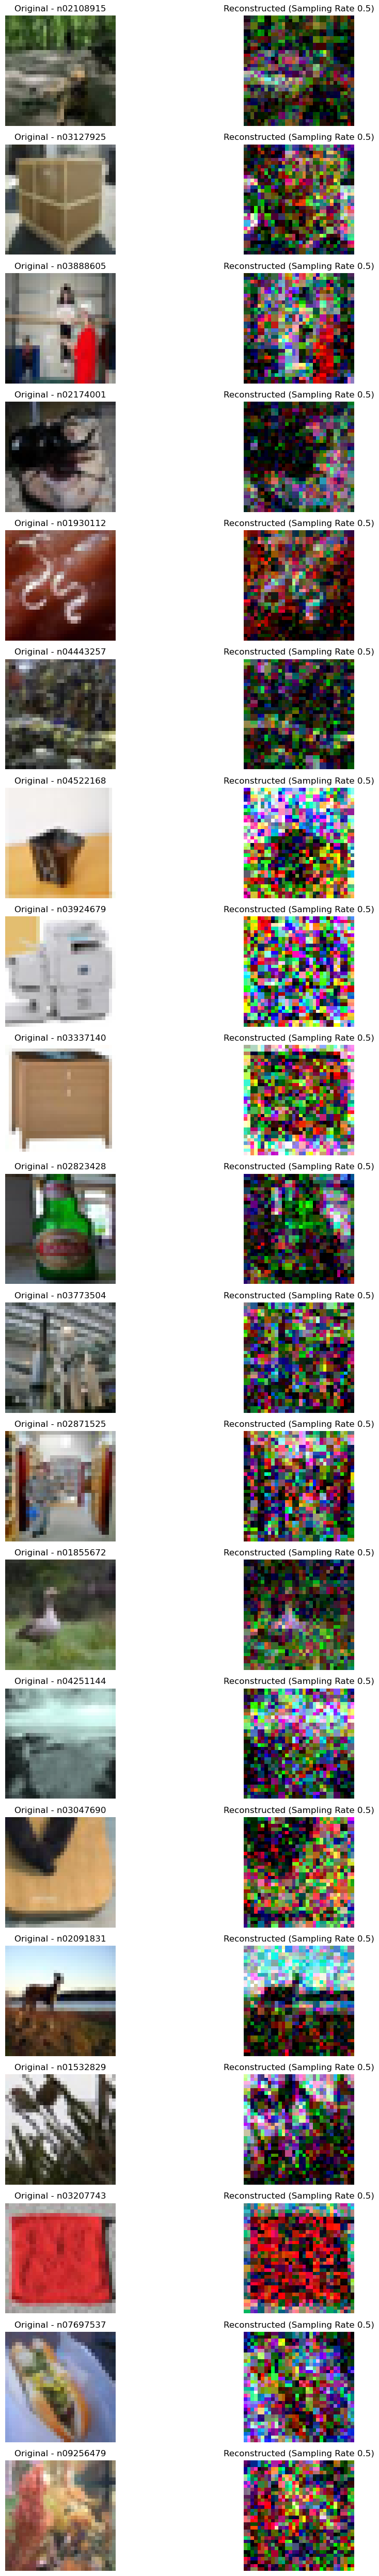

In [111]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

sampling_rate_to_plot = 0.5
filtered_results = [r for r in results if r['sampling_rate'] == sampling_rate_to_plot]

rows = len(filtered_results)
plt.figure(figsize=(12, rows * 2.5))

for i, entry in enumerate(filtered_results):
    cls = entry['class']
    orig_path = entry['image_path']
    recon_img = entry['reconstructed_image']  # RGB image

    # Load original RGB image
    orig_img = Image.open(orig_path).convert('RGB').resize((32, 32))
    orig_np = np.array(orig_img) / 255.0  # RGB in [0, 1]

    # Plot original image
    plt.subplot(rows, 2, 2*i + 1)
    plt.imshow(orig_np)
    plt.title(f"Original - {cls}")
    plt.axis('off')

    # Plot reconstructed image
    plt.subplot(rows, 2, 2*i + 2)
    plt.imshow(recon_img)
    plt.title(f"Reconstructed (Sampling Rate {sampling_rate_to_plot})")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Next, the sampling rate = 0.75

In [16]:
import numpy as np
import cvxpy as cp
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import pywt

# ───────────────────────────────────────────────
# 1. Wavelet Transform Utilities (Haar)
# ───────────────────────────────────────────────
def apply_wavelet(img):
    return pywt.dwt2(img, 'haar')

def apply_inverse_wavelet(coeffs):
    return pywt.idwt2(coeffs, 'haar')

# ───────────────────────────────────────────────
# 2. RGB CS Reconstruction Function
# ───────────────────────────────────────────────
def compressive_sensing_reconstruct_rgb(img_rgb, sampling_rate):
    h, w, _ = img_rgb.shape
    recon_rgb = np.zeros_like(img_rgb)

    for c in range(3):  # R, G, B channels
        img = img_rgb[..., c]
        LL, (LH, HL, HH) = apply_wavelet(img)

        x_true = np.concatenate([
            LL.flatten(), LH.flatten(), HL.flatten(), HH.flatten()
        ])
        n = x_true.size
        m = int(sampling_rate * n)

        A = np.random.randn(m, n) / np.sqrt(m)
        y = A @ x_true

        x_hat = cp.Variable(n)
        objective = cp.Minimize(cp.norm(x_hat, 1))
        constraints = [A @ x_hat == y]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.SCS, verbose=False)

        # Reconstruct wavelet bands
        split1 = LL.size
        split2 = split1 + LH.size
        split3 = split2 + HL.size

        LLr = x_hat.value[:split1].reshape(LL.shape)
        LHr = x_hat.value[split1:split2].reshape(LH.shape)
        HLr = x_hat.value[split2:split3].reshape(HL.shape)
        HHr = x_hat.value[split3:].reshape(HH.shape)

        coeffs_recon = (LLr, (LHr, HLr, HHr))
        recon_channel = apply_inverse_wavelet(coeffs_recon)
        recon_rgb[..., c] = np.clip(recon_channel, 0, 1)

    return recon_rgb

# ───────────────────────────────────────────────
# 3. Simulate CS on Selected Images (RGB)
# ───────────────────────────────────────────────
def simulate_cs_reconstruction(selected_images, sampling_rates=[0.75]):
    results = []

    for rate in sampling_rates:
        print(f"\n🔍 Processing sampling rate: {rate}")
        for cls, img_path in selected_images:
            img = Image.open(img_path).convert('RGB').resize((32, 32))
            img_np = np.array(img) / 255.0  # Shape: (32, 32, 3)

            recon_img = compressive_sensing_reconstruct_rgb(img_np, rate)

            # For PSNR/SSIM: compare grayscale versions
            gray_orig = np.mean(img_np, axis=2)
            gray_recon = np.mean(recon_img, axis=2)
            psnr_val = psnr(gray_orig, gray_recon, data_range=1.0)
            ssim_val = ssim(gray_orig, gray_recon, data_range=1.0)

            results.append({
                "class": cls,
                "sampling_rate": rate,
                "psnr": round(psnr_val, 2),
                "ssim": round(ssim_val, 3),
                "image_path": img_path,
                "reconstructed_image": recon_img  # full RGB image
            })

    return results

# ───────────────────────────────────────────────
# 4. Select 20 Diverse Test Images
# ───────────────────────────────────────────────
selected_images = []
all_classes = sorted(os.listdir('data/test'))
selected_classes = random.sample(all_classes, 20)

for cls in selected_classes:
    class_path = os.path.join('data/test', cls)
    images = os.listdir(class_path)
    image_file = random.choice(images)
    selected_images.append((cls, os.path.join(class_path, image_file)))

# ───────────────────────────────────────────────
# 5. Run Reconstruction and Save Results
# ───────────────────────────────────────────────
results = simulate_cs_reconstruction(selected_images)

df = pd.DataFrame(results)
df.to_pickle("reconstructed_df.pkl")
print("✅ Saved DataFrame with RGB CS-reconstructed images: reconstructed_df.pkl")
print(df.head())



🔍 Processing sampling rate: 0.75
✅ Saved DataFrame with RGB CS-reconstructed images: reconstructed_df.pkl
       class  sampling_rate   psnr   ssim  \
0  n04435653           0.75  24.19  0.876   
1  n04149813           0.75  27.31  0.858   
2  n02099601           0.75  28.16  0.945   
3  n13133613           0.75  28.25  0.903   
4  n02120079           0.75  27.74  0.914   

                                  image_path  \
0  data/test\n04435653\n0443565300000185.jpg   
1  data/test\n04149813\n0414981300000611.jpg   
2  data/test\n02099601\n0209960100001004.jpg   
3  data/test\n13133613\n1313361300000104.jpg   
4  data/test\n02120079\n0212007900000665.jpg   

                                 reconstructed_image  
0  [[[0.6399511275361826, 0.43204382433172306, 0....  
1  [[[0.41040788775544107, 0.2066093001087574, 0....  
2  [[[0.6164199572870779, 0.47459343370738166, 0....  
3  [[[0.6856111874164641, 0.7262185335373814, 0.7...  
4  [[[0.31185920779102017, 0.2759161086488221, 0....  


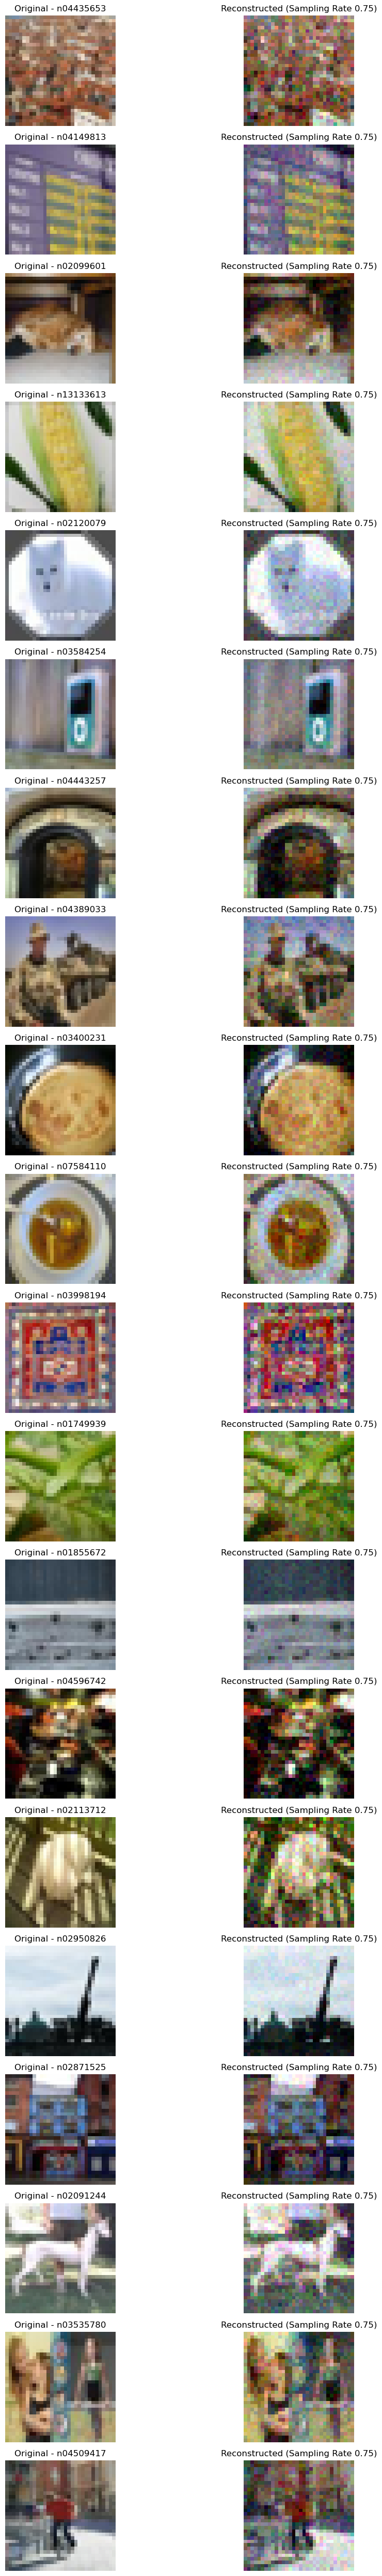

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

sampling_rate_to_plot = 0.75
filtered_results = [r for r in results if r['sampling_rate'] == sampling_rate_to_plot]

rows = len(filtered_results)
plt.figure(figsize=(12, rows * 2.5))

for i, entry in enumerate(filtered_results):
    cls = entry['class']
    orig_path = entry['image_path']
    recon_img = entry['reconstructed_image']  # RGB image

    # Load original RGB image
    orig_img = Image.open(orig_path).convert('RGB').resize((32, 32))
    orig_np = np.array(orig_img) / 255.0  # RGB in [0, 1]

    # Plot original image
    plt.subplot(rows, 2, 2*i + 1)
    plt.imshow(orig_np)
    plt.title(f"Original - {cls}")
    plt.axis('off')

    # Plot reconstructed image
    plt.subplot(rows, 2, 2*i + 2)
    plt.imshow(recon_img)
    plt.title(f"Reconstructed (Sampling Rate {sampling_rate_to_plot})")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Test reconstructed images on both model versions:
### Models fine-tuned on original data
### Models fine-tuned on compressed data

# Testing on Models fine-tuned on uncompressed data


In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd
import os

# ──────────────────────────────────────────────────────
# Step 1: Load the reconstructed CS images DataFrame
# ──────────────────────────────────────────────────────
df = pd.read_pickle("reconstructed_df.pkl")  # contains: 'class', 'reconstructed_image'

# ──────────────────────────────────────────────────────
# Step 2: Build class-to-index mapping using ORIGINAL training data
# ──────────────────────────────────────────────────────
train_dir = 'data/train'  # original training directory
class_to_idx = {cls: idx for idx, cls in enumerate(sorted(os.listdir(train_dir)))}

# ──────────────────────────────────────────────────────
# Step 3: Define transform (same used in original training)
# ──────────────────────────────────────────────────────
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# ──────────────────────────────────────────────────────
# Step 4: Convert each RGB reconstructed image to tensor
# ──────────────────────────────────────────────────────
tensor_list = []
label_list = []

for _, row in df.iterrows():
    img_rgb = row['reconstructed_image']  # shape: (32, 32, 3), float32 in [0,1]
    img_uint8 = (img_rgb * 255).clip(0, 255).astype('uint8')
    pil_rgb = Image.fromarray(img_uint8, mode='RGB')  # already RGB
    tensor = transform(pil_rgb)
    tensor_list.append(tensor)
    label_list.append(class_to_idx[row['class']])  # match original training class indices

imgs_tensor = torch.stack(tensor_list)
labels_tensor = torch.tensor(label_list)

# ──────────────────────────────────────────────────────
# Step 5: Create Tiny Dataset and DataLoader
# ──────────────────────────────────────────────────────
class CachedReconstructedDataset(Dataset):
    def __init__(self, imgs, labels):
        self.imgs = imgs
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

loader = DataLoader(CachedReconstructedDataset(imgs_tensor, labels_tensor),
                    batch_size=32, shuffle=False)

# ──────────────────────────────────────────────────────
# Step 6: Load the fine-tuned ResNet18 model (trained on original data)
# ──────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 100)
model.load_state_dict(torch.load('resnet_original_uncompressed_finetuned.pth', map_location=device))
model.to(device).eval()

# ──────────────────────────────────────────────────────
# Step 7: Evaluate
# ──────────────────────────────────────────────────────
correct = total = 0
with torch.no_grad():
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

accuracy = 100 * correct / total
print(f"\n Accuracy on CS-reconstructed RGB images using original-trained model: {accuracy:.2f}%")


C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



 Accuracy on CS-reconstructed RGB images using original-trained model: 15.00%


# Testing on Models fine-tuned on compressed data



In [100]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import pickle

# —— Step 1: Save class_to_idx from compressed training set ——
train_dir = 'data/train_db4_95_comp'
class_folders = sorted(os.listdir(train_dir))
class_to_idx = {cls: idx for idx, cls in enumerate(class_folders)}

# Save the mapping for consistent testing
with open('class_to_idx_wavelet.pkl', 'wb') as f:
    pickle.dump(class_to_idx, f)

print(" Saved class_to_idx mapping to class_to_idx_wavelet.pkl")

# —— Step 2: Define transforms (same for train and val) ——
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# —— Step 3: Load datasets ——
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=train_dir, transform=transform)  # optional: use actual val

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# —— Step 4: Initialize and fine-tune ResNet18 ——
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 100)
model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.fc.parameters(), lr=0.01, momentum=0.9)

# —— Step 5: Train loop (1 epoch for demo) ——
print("\n Fine-tuning ResNet18 on compressed wavelet data...")
model_resnet.train()
for epoch in range(5):
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch 1: Loss = {running_loss/len(train_loader):.4f}, Accuracy = {100*correct/total:.2f}%")

# —— Step 6: Save model ——
torch.save(model_resnet.state_dict(), 'resnet18_finetuned_wavelet.pth')
print(" Saved fine-tuned model as resnet18_finetuned_wavelet.pth")


 Saved class_to_idx mapping to class_to_idx_wavelet.pkl


C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Fine-tuning ResNet18 on compressed wavelet data...
Epoch 1: Loss = 3.4716, Accuracy = 25.15%
Epoch 1: Loss = 3.1807, Accuracy = 30.60%
Epoch 1: Loss = 3.1200, Accuracy = 32.20%
Epoch 1: Loss = 3.0863, Accuracy = 32.79%
Epoch 1: Loss = 3.0783, Accuracy = 33.11%
 Saved fine-tuned model as resnet18_finetuned_wavelet.pth


In [104]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt


# —— Step 7: Load reconstructed images and evaluate ——
df = pd.read_pickle("reconstructed_df.pkl")
with open('class_to_idx_wavelet.pkl', 'rb') as f:
    class_to_idx = pickle.load(f)

tensor_list = []
label_list = []

for _, row in df.iterrows():
    class_name = row['class']
    if class_name not in class_to_idx:
        continue
    img_rgb = row['reconstructed_image']
    img_uint8 = (img_rgb * 255).clip(0, 255).astype('uint8')
    pil_rgb = Image.fromarray(img_uint8, mode='RGB')
    tensor = transform(pil_rgb)
    tensor_list.append(tensor)
    label_list.append(class_to_idx[class_name])

imgs_tensor = torch.stack(tensor_list)
labels_tensor = torch.tensor(label_list)

class CachedReconstructedDataset(Dataset):
    def __init__(self, imgs, labels):
        self.imgs = imgs
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx): return self.imgs[idx], self.labels[idx]

loader = DataLoader(CachedReconstructedDataset(imgs_tensor, labels_tensor),
                    batch_size=32, shuffle=False)

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 100)
model.load_state_dict(torch.load('resnet18_finetuned_wavelet.pth', map_location=device))
model.to(device).eval()

correct = total = 0
predictions = []
with torch.no_grad():
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        predictions.extend(preds.cpu().tolist())
        correct += (preds == y).sum().item()
        total += y.size(0)

accuracy = 100 * correct / total

print(f"\n Accuracy on CS-reconstructed RGB images (wavelet-trained model): {accuracy:.2f}%")



C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



 Accuracy on CS-reconstructed RGB images (wavelet-trained model): 5.00%


# Analyze performance differences and determine which approach is more robust

In [ ]:
# comment based on the above results